In [16]:
# =================================================
# Your names:



# =================================================
# Automatic Speech Recognition WS-17-18
# Exercise 7, Task 7.2

# Please make use of the functions and the variables
# provided in this notebook when you write your answer codes.
import matplotlib.pyplot as plt
import numpy as np

def Read(filename):
    x_data = []
    y_data = []
    # Read function:
    #   Reads the 2D data from the file path
    #   Returns a list for each component of the data.
    with open(filename) as f:
        data_str = f.readlines()
        for i in range(0, len(data_str)):
            data_point = data_str[i].split()
            x_data.append(float(data_point[0]))
            y_data.append(float(data_point[1]))
        return x_data, y_data

Let's see how the data look like.


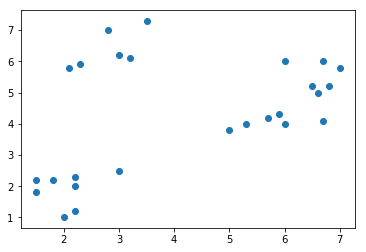

We can see 3 or 4 groups of points, right?

We will model this data with 4 densities (L=4).

Initialization done.
Initial density:
Mean: [4.134615384615384, 4.273076923076923]
Variance: [3.9630325443786987, 3.3327366863905326]


In [17]:
# This is another helper code cell which introduces
# the name of variables to be used in your solution
# as well as the data you will use.
# The task starts at the next cell.

# Download the data from L2P and put the path here:
data = "./observations_ex7.data"
data_x, data_y = Read(data)

# Visualize the data
print("Let's see how the data look like.")
plt.scatter(data_x, data_y)
plt.show()

print("We can see 3 or 4 groups of points, right?\n")
print("We will model this data with 4 densities (L=4).\n")

# Set the hyperparameters given in the text:
L = 4  # Maximum number of densities
R = 10  # Number of iterations
eps_u = [0.1, 0.1]  # Vector: epsilon * u

# Number of data points:
N = len(data_x)

# Compute the initial mean
init_mean = [0.,0.]
for i in range(0,N):
    init_mean[0] += float(data_x[i])
    init_mean[1] += float(data_y[i])
init_mean[0] *= 1./float(N)
init_mean[1] *= 1./float(N)

# Compute the initial variance
init_var = [0., 0.]
for i in range(0,N):
    init_var[0] += (data_x[i]-init_mean[0])*(data_x[i]-init_mean[0])
    init_var[1] += (data_y[i]-init_mean[1])*(data_y[i]-init_mean[1])
init_var[0] *= 1./float(N)
init_var[1] *= 1./float(N)

def Init():
    # Add the initial density to the list.
    global Mean
    Mean = []  # Mean is a list in which Mean[l] stores the mean vector for the density l.
    Mean.append(init_mean)
    
    global Var
    Var = init_var  # Pooled variance.
    
    global p_l
    p_l = []  # Array to store p(l) (cf. the notation given in the sheet).
    p_l.append(1)

    global N_l  # Array to store N_l (cf. the notation given in the sheet).
    N_l = np.zeros([L])  
    N_l = list(N_l)
    N_l[0] = N
    
    global A  # Array to store the membership of each point.
    A = np.zeros([N], dtype=np.int32)
    A = list(A)
    print('Initialization done.')

Init()
print('Initial density:')
print('Mean:', Mean[0])
print('Variance:', Var)

In [18]:
#   Functions for (a)
def Gaussian(x, mean, var):
    # Returns p(x|l) (cf. the notation given in the sheet)
    # You can use for example np.exp for the exponential
    # For the number 'pi', you can e.g. use 'np.pi'
    # TODO You code here 

    prefix=1/(2*np.pi*np.sqrt(var[0])*np.sqrt(var[1]))
    expo=(x[0]-mean[0])*(x[0]-mean[0])/var[0]+(x[1]-mean[1])*(x[1]-mean[1])/var[1]
    result=prefix*np.exp(-1/2*expo)
    return result


def Assign(K):
    # Update the membership of each points
    # (list A introduced in the previous cell)
    # K: current number of densities
    # TODO You code here
    for i in range(0,N):
        temp=0
        k=0
        for k in range(0,K):
            if Gaussian([data_x[i],data_y[i]],Mean[k],Var)>temp:
                temp=Gaussian([data_x[i],data_y[i]],Mean[k],Var)
                assign=k
        A[i]=assign
    return A



In [19]:
# Function for (c)
def EstimateParameters(K):
    # Re-estimate the means and variances for all densities
    # K: current number of densities
    # TODO You code here
    for i in range (0,L):
        N_l[i]=0
    
    _mean = np.zeros([N,2])
    _var = np.zeros(2)
    for i in range(0,N):
        for k in range (0,K):
            if A[i]==k :
                _mean[k][0] += float(data_x[i])  
                _mean[k][1] += float(data_y[i]) 
                N_l[k]=N_l[k]+1
     
  
    for k in range (0,K):
        _mean[k][0]*= 1./float(N_l[k])
        _mean[k][1]*= 1./float(N_l[k])
        Mean[k]=[_mean[k][0],_mean[k][1]]
        
    
    for i in range(0,N):
        for k in range (0,K):
            if A[i]==k :
                _var[0] += (data_x[i]-_mean[k][0])*(data_x[i]-_mean[k][0])
                _var[1] += (data_y[i]-_mean[k][1])*(data_y[i]-_mean[k][1])            
    _var[0] *= 1./float(N)
    _var[1] *= 1./float(N)
    Var=[_var[0],_var[1]]
           
    return 0

In [20]:
# Functions for (d)
def FindMinLogLike(K):
    # Return the index of the density with the lowest likelihood.
    # TODO You code here
    log_value=[]
    for i in range (0,K):
        log_value.append(0)
        for j in range (0,N):
            if A[j]==i:
                coeff=1
            else :
                coeff=0
            log_value[i]+=coeff*np.log(p_l[i]*Gaussian([data_x[j],data_y[j]], Mean[i], Var)) 
    
    return log_value.index(min(log_value))

def SplitDensity(l):
    # Split the density l.
    # If needed: When you have a list L, you can use L.pop(n) to remove the
    # element in position n of the list L.
    # TODO You code here
    split_index=FindMinLogLike(l)
    
    Mean[split_index]=[Mean[split_index][0]-0.1,Mean[split_index][1]-0.1]
    Mean.append([Mean[split_index][0]+0.1,Mean[split_index][1]+0.1])
    
    return 0

In [21]:
Init()
# Apply the algorithm to the data.
# Report the mean, variance and membership for each split iteration.


SplitDensity(1)
for i in range(0,R):    
    Assign(2)  
    EstimateParameters(2)


print("The mean is as follows:")
print(Mean)
print("The variance is as follows: ")
print(Var)
print("The membership for each split iteration is as follows:")
print(A)
# TODO You code here


# Checkpoint: after the first split, you should get the following:
# Mean: [[5.06, 5.33], [2.05, 1.90]]
# Var: [3.96, 3.33]
# Membership: [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Initialization done.
The mean is as follows:
[[2.0499999999999998, 1.8999999999999999], [5.0611111111111109, 5.3277777777777766]]
The variance is as follows: 
[3.9630325443786987, 3.3327366863905326]
The membership for each split iteration is as follows:
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


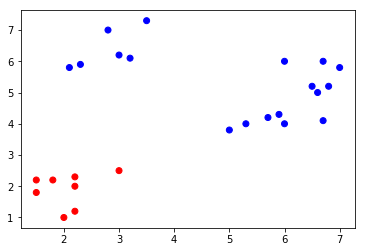

In [7]:
# Visualization of the split you obtained

# This cell is a helper to show you an example method to plot
# data points with different colors.

split_example = [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Colors = ['b', 'r', 'y', 'm']  # blue, red, yellow, magenta. No need to modify this list.

color = [Colors[split_example[i]] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()

# You will use the next cells below to plot your own results.

Split 0


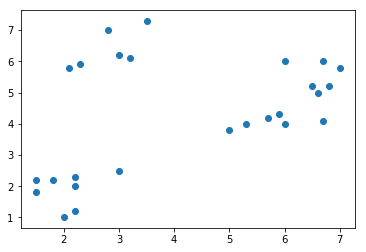

In [8]:
# Plot for the last question
# Split 0
print("Split 0")
plt.scatter(data_x, data_y)
plt.show()
# TODO You code here

Split 1
Initialization done.
The mean is as follows:
[[2.0499999999999998, 1.8999999999999999], [5.0611111111111109, 5.3277777777777766]]
The variance is as follows: 
[3.9630325443786987, 3.3327366863905326]
The membership for each split iteration is as follows:
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


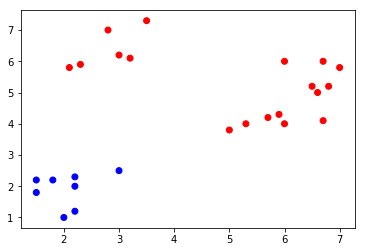

In [9]:
# Plot for the last question
# Split 1
print("Split 1")
# TODO You code here
Init()
SplitDensity(1)
for i in range(0,R):    
    Assign(2)  
    EstimateParameters(2)

print("The mean is as follows:")
print(Mean)
print("The variance is as follows: ")
print(Var)
print("The membership for each split iteration is as follows:")
print(A)

Colors = ['b', 'r', 'y', 'm']  # blue, red, yellow, magenta. No need to modify this list.

color = [Colors[A[i]] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()




Split 2
The mean is as follows:
[[2.0499999999999998, 1.8999999999999999], [2.8166666666666664, 6.3833333333333329], [6.1833333333333345, 4.7999999999999998]]
The variance is as follows: 
[3.9630325443786987, 3.3327366863905326]
The membership for each split iteration is as follows:
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


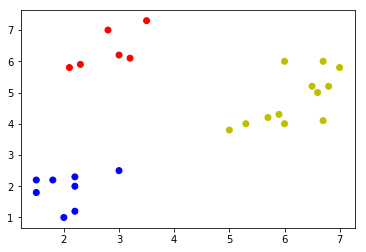

In [10]:
# Plot for the last question
# Split 2
print("Split 2")
# TODO You code here
p_l.append(0)
p_l[0]=N_l[0]/N
p_l[1]=N_l[1]/N

SplitDensity(2)
for i in range(0,R):    
    Assign(3)  
    EstimateParameters(3)

print("The mean is as follows:")
print(Mean)
print("The variance is as follows: ")
print(Var)
print("The membership for each split iteration is as follows:")
print(A)

Colors = ['b', 'r', 'y', 'm']  # blue, red, yellow, magenta. No need to modify this list.

color = [Colors[A[i]] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()





Split 3
Split 2
The mean is as follows:
[[2.0499999999999998, 1.8999999999999999], [2.8166666666666664, 6.3833333333333329], [5.7666666666666666, 4.0666666666666664], [6.5999999999999996, 5.5333333333333323]]
The variance is as follows: 
[3.9630325443786987, 3.3327366863905326]
The membership for each split iteration is as follows:
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3]


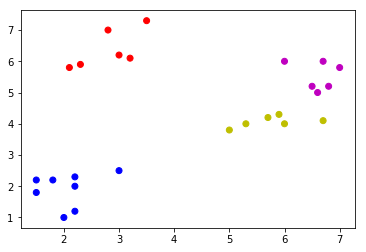

In [11]:
# Plot for the last question
# Split 3
print("Split 3")

# TODO You code here
p_l.append(0)
p_l[0]=N_l[0]/N
p_l[1]=N_l[1]/N
p_l[2]=N_l[2]/N

SplitDensity(3)
for i in range(0,R):    
    Assign(4)  
    EstimateParameters(4)

print("The mean is as follows:")
print(Mean)
print("The variance is as follows: ")
print(Var)
print("The membership for each split iteration is as follows:")
print(A)

Colors = ['b', 'r', 'y', 'm']  # blue, red, yellow, magenta. No need to modify this list.

color = [Colors[A[i]] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()
# TODO You code here

In [12]:
# End of the exercise 7.2